In [1]:
%matplotlib widget
from helper import *

# Results

This Chapter is intended to analyze and compare the newly derived controller to the pseudoinversed Jacobian approach, which is common in literature. It shows the advantages of the proposed method over the classical IDK approach and shows the advantage of the directional manipulability optimization over the classical Yoshikawa manipulability optimization when it comes to trajectory tracking. Besides the motion controller, computational efficiency and advantages of the double cover property of the unit dual quaternionic kinematics formulation are also shown.

## Proposed Motion controller vs. classical approaches
 These tests are based on the robot welding example and interactive showcases of the predictive task directional manipulability optimization of the robot configuration.
The depicted motion runs through the wrist and shoulder singularities, as these are common during the welding process. The motion commands are simplified to easily show the effect of the predictive controller vs the standard approach.

In [2]:
fk = ForwardKinematics()

q1 = np.array([deg2rad(0), deg2rad(0), deg2rad(0), deg2rad(90), deg2rad(10), deg2rad(-90), deg2rad(0)])

quat0 = Quaternion.fromAxisAngle(np.pi*0.5, np.array([0,1,0]))
quat1 = Quaternion.fromAxisAngle(np.pi*0.5, np.array([0,0,1]))


x1 = DualQuaternion.fromQuatPos(quat0, np.array([0.350, 0, 1.138]))
x2 = DualQuaternion.fromQuatPos(quat0, np.array([0.815, 0, 1.138]))
x3 = DualQuaternion.fromQuatPos(quat1*quat0, np.array([0.815, 0, 1.138]))     
x4 = DualQuaternion.fromQuatPos(quat0*quat0, np.array([0.815, 0, 1.138]))  
x5 = DualQuaternion.fromQuatPos(quat0*quat0, np.array([0, 0, 1.138]))  
x6 = DualQuaternion.fromQuatPos(quat0*quat0, np.array([0, 0.5, 1.138]))  

task_list = np.array([MoveJoint(q1, 2), MoveLinear(fk.getFK(q1), x1, 3), MoveLinear(x1, x2, 4), MoveLinear(x2, x3, 2), WaitTime(1), MoveLinear(x3, x1, 4),
                      MoveLinear(x1, x2, 4), MoveLinear(x2, x4, 2), WaitTime(1)])

sim_classic = Simulation(task_list, method = "classic")

sim_classic.start()

As visible from the Simulation environment, the classic differential kinematics approach with Yoshikawa manipulability gradient cannot respect joint position or velocity limits and has violent jumps in the robot's singular configuration. The following code block will show the predictive motion controller proposed in this thesis.

In [3]:
sim_qp = Simulation(task_list, method = "qp")

sim_qp.start()

The proposed method shows the predictive nature of the directional manipulability optimization. Due to the prediction of the task direction, the cobot is able to adjust its configuration in an optimized manner to move along the desired trajectory. The following plots will show this in greater detail. They show the joint positions and velocities for the classic and the proposed method. The joint position and velocity limit violations for the classic method are visible. Note that the joint velocity bound is $[-120\frac{deg}{s}, 120\frac{deg}{s}]$ and that the joint positions are limited to $[-180deg, 180deg]$ and to $\pm 120deg$ and $\pm 150deg$ for joint 2 and joint4 respectively.

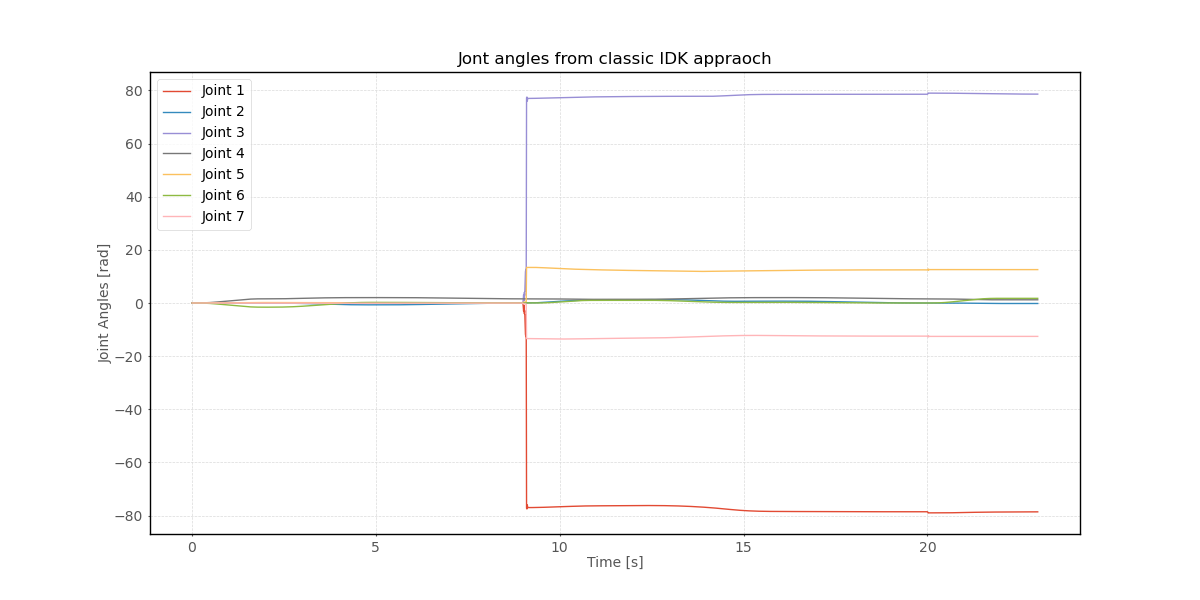

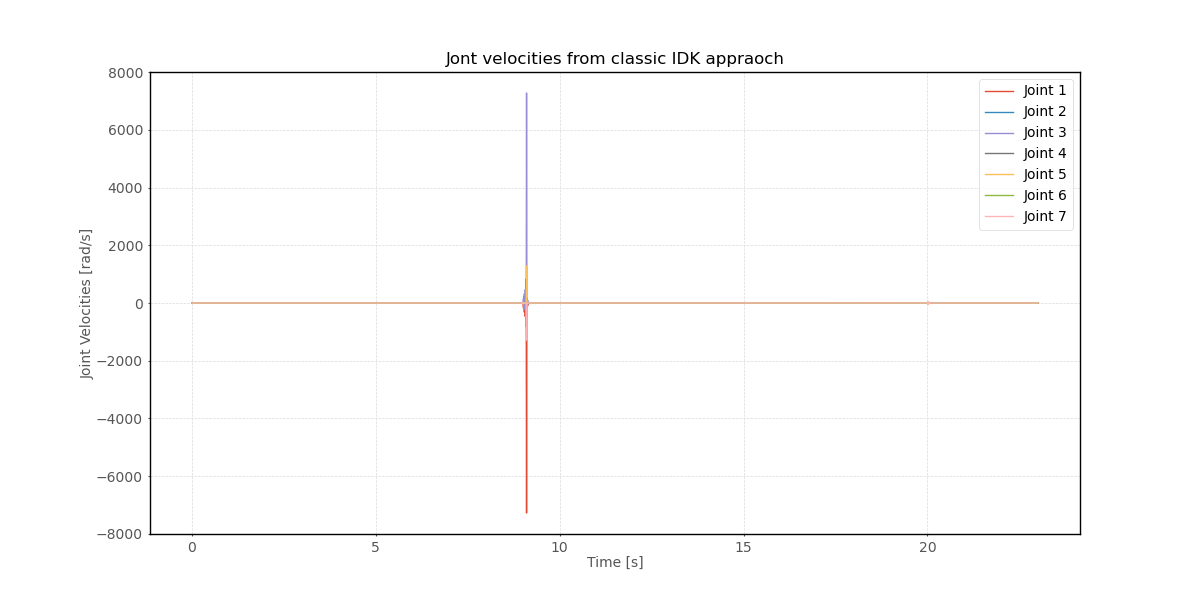

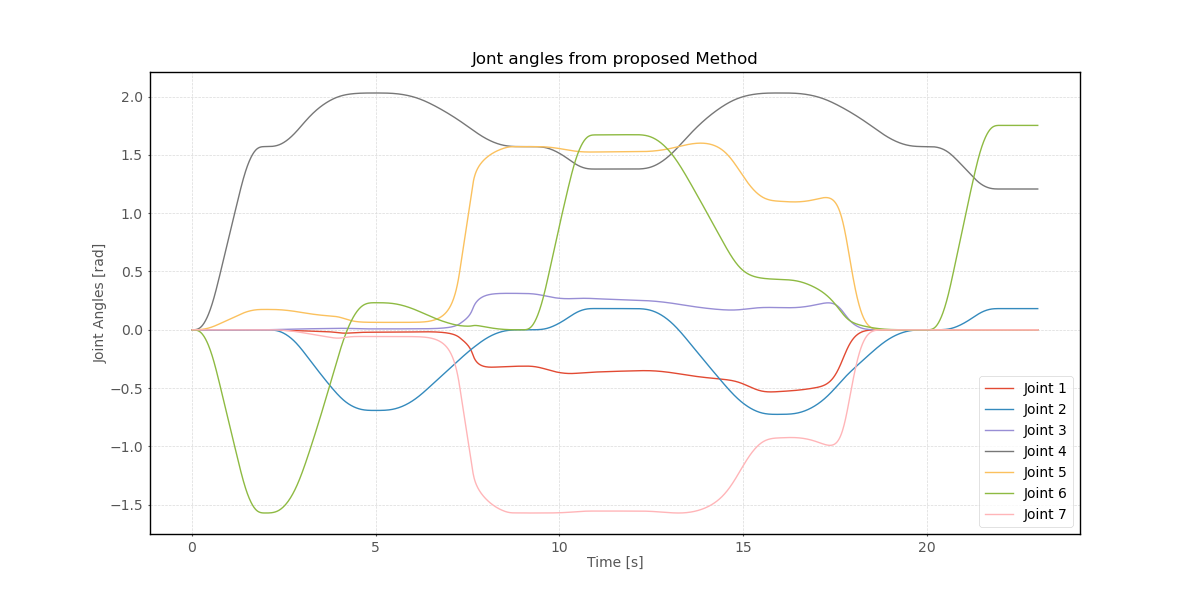

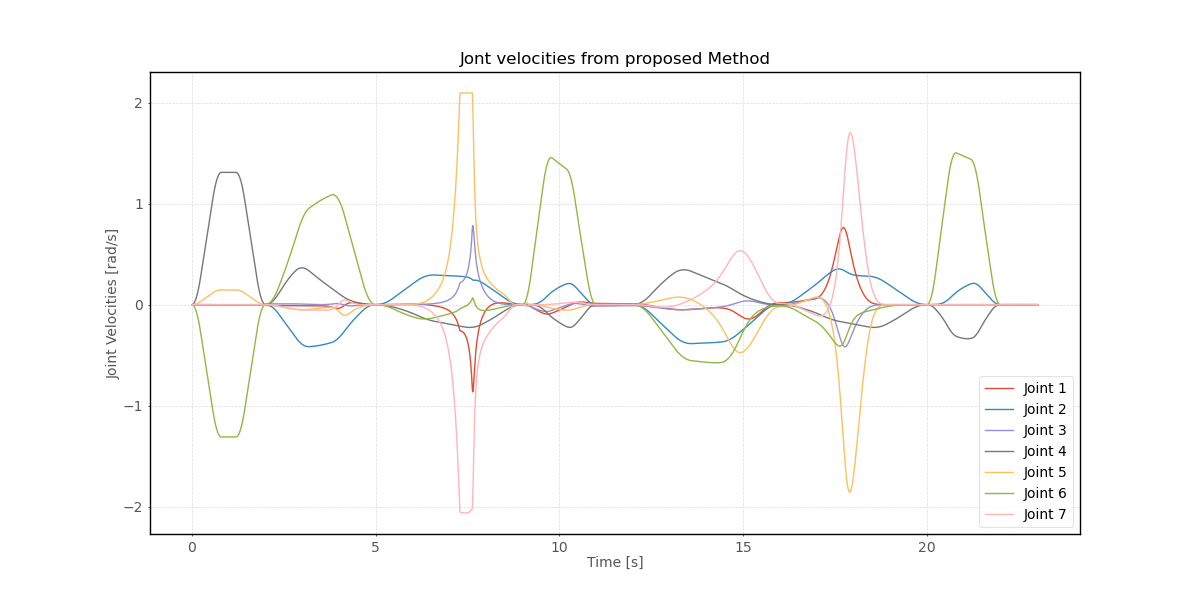

In [4]:
plotJointVariables(sim_classic.time_list, sim_classic.q_list, "Jont angles from classic IDK appraoch", "Joint Angles [rad]")
plotJointVariables(sim_classic.time_list, sim_classic.q_dot_list, "Jont velocities from classic IDK appraoch", "Joint Velocities [rad/s]")
plotJointVariables(sim_qp.time_list, sim_qp.q_list, "Jont angles from proposed Method", "Joint Angles [rad]")
plotJointVariables(sim_qp.time_list, sim_qp.q_dot_list, "Jont velocities from proposed Method", "Joint Velocities [rad/s]")

Contrary to the classic approach, the proposed method with predictive directional manipulability optimization is able to guarantee that the joint velocity and position limits are not violated. This is because the robot preemptively moves in the right, optimized configuration within its nullspace to be able to execute the next motion command without the need for rapid readjustment of the configuration. Besides this, the dampening of the acceleration positively affects on the velocity smoothness.

Another noteworthy comparison is the comparison of the directional manipulability optimization vs the Yoshikawa manipulability optimization. This is done with the proposed quadratic program formulation. Here, only the directional manipulability gradient is replaced with the Yoshikawa manipulability gradient. The remaining architecture is kept the same. The following code block will generate a simulation environment that shows the performance of the Yoshikawa controller.

In [5]:
sim_qp_yoshikawa = Simulation(task_list, method = "qp_yoshikawa")

sim_qp_yoshikawa.start()

Both controllers can keep the joint state within the bounds. This can be seen in the following plots.

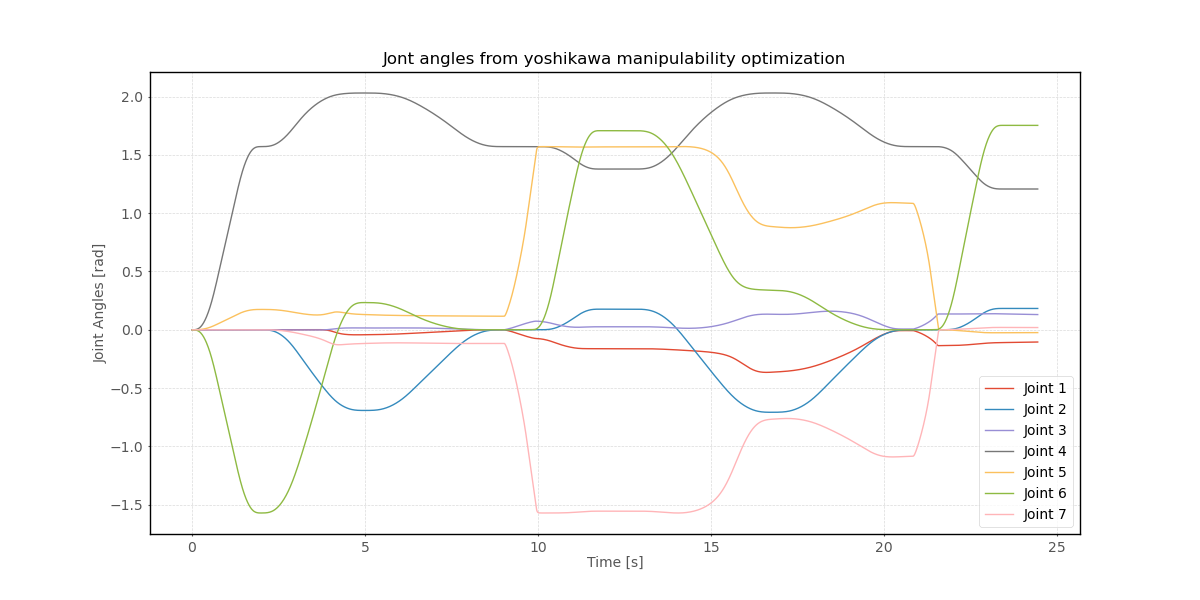

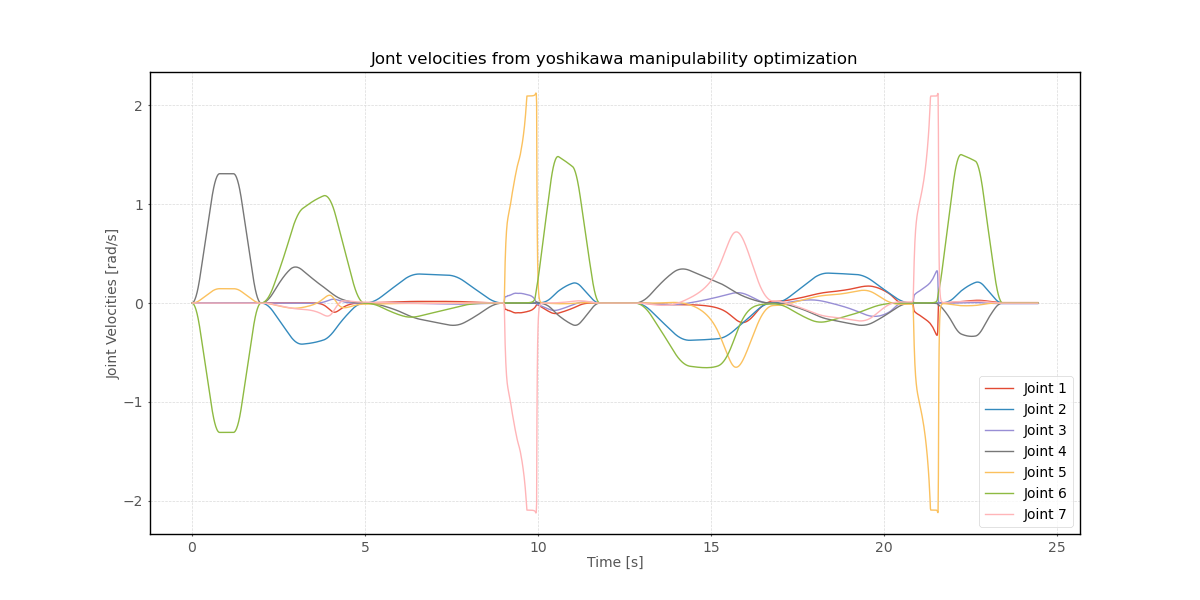

In [6]:
plotJointVariables(sim_qp_yoshikawa.time_list, sim_qp_yoshikawa.q_list, "Jont angles from yoshikawa manipulability optimization", "Joint Angles [rad]")
plotJointVariables(sim_qp_yoshikawa.time_list, sim_qp_yoshikawa.q_dot_list, "Jont velocities from yoshikawa manipulability optimization", "Joint Velocities [rad/s]")

The drawback of the general manipulability is that the robot is not optimized for the task direction but for all directions. This is visible in the time scaling factor that was introduced in the proposed method. The following comparison will show the Yoshikawa manipulability vs the prosed directional manipulability method.

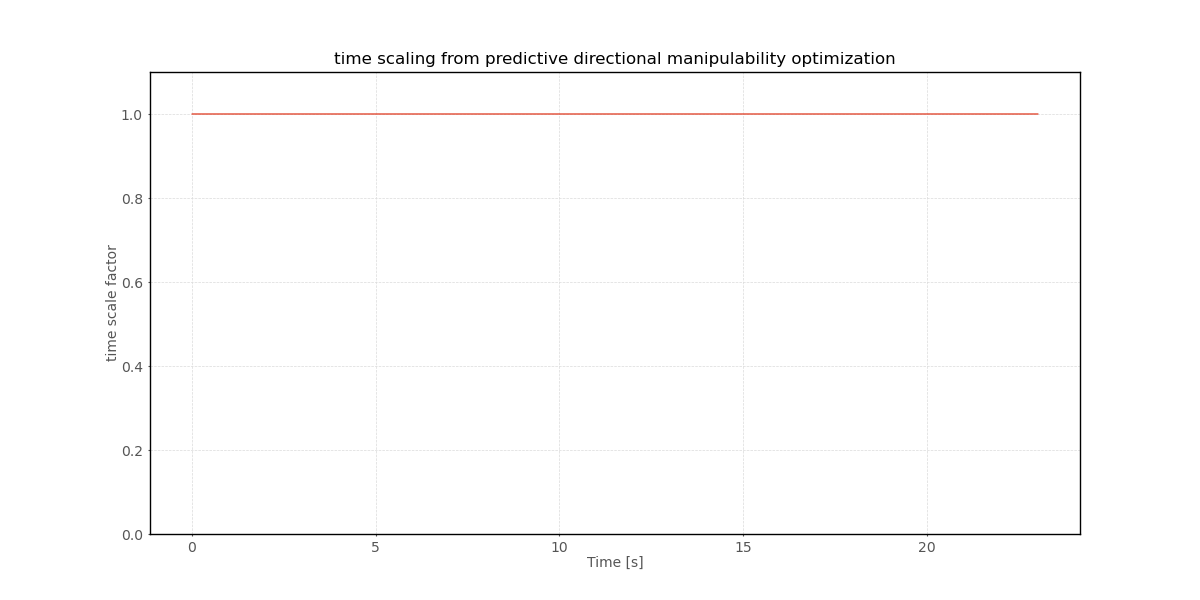

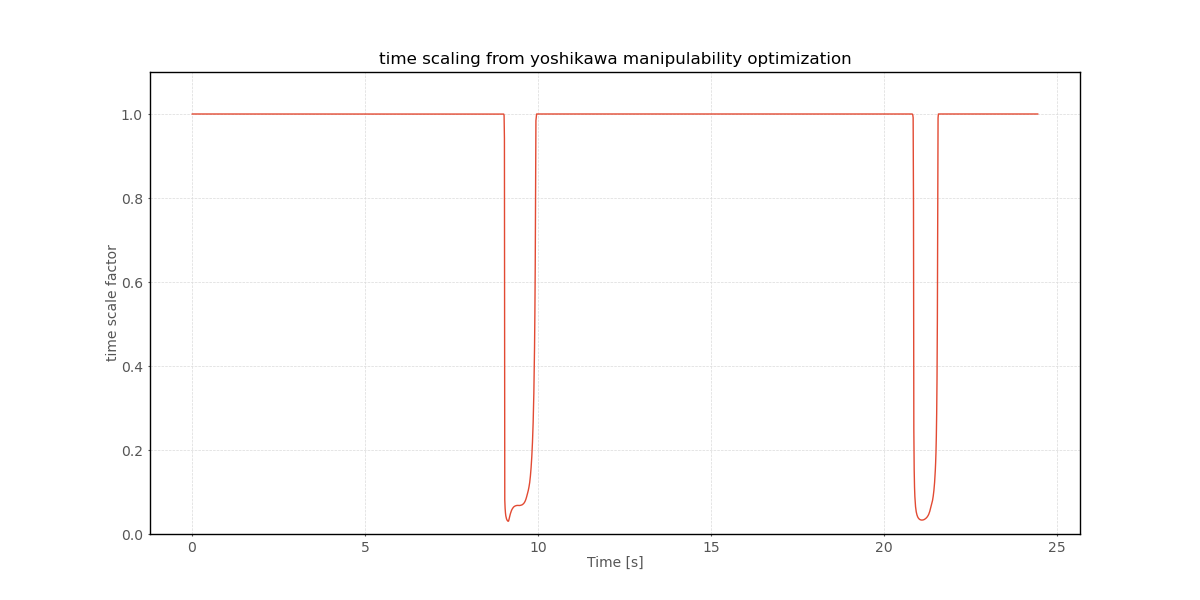

In [7]:
plotTimeScale(sim_qp.time_list, sim_qp.time_scale_list, "time scaling from predictive directional manipulability optimization")
plotTimeScale(sim_qp_yoshikawa.time_list, sim_qp_yoshikawa.time_scale_list, "time scaling from yoshikawa manipulability optimization")

It is visible that the trajectory is scaled down for longer and more aggressively in the case of the Yoshikawa manipulability optimization, which results in a deviation from the original trajectory definition as the desired task velocity is not kept. The directional manipulability optimization needs no or very little time scaling, which results in more accurate trajectory tracking results. The norm of the trajectory tracking error is followingly defined as $\|\underline{\xi}_{des} - fk(\theta)\|$ is generally similar in both cases, only in the area where the time scaling is applied in the Yoshikawa manipulability optimization approach, the error norm is increased. This stems from the fact that the solver uses the error threshold to a higher capacity to find a suitable solution. No other advantages are visible in the comparison of the proposed method and the Yoshikawa manipulability optimization approach.

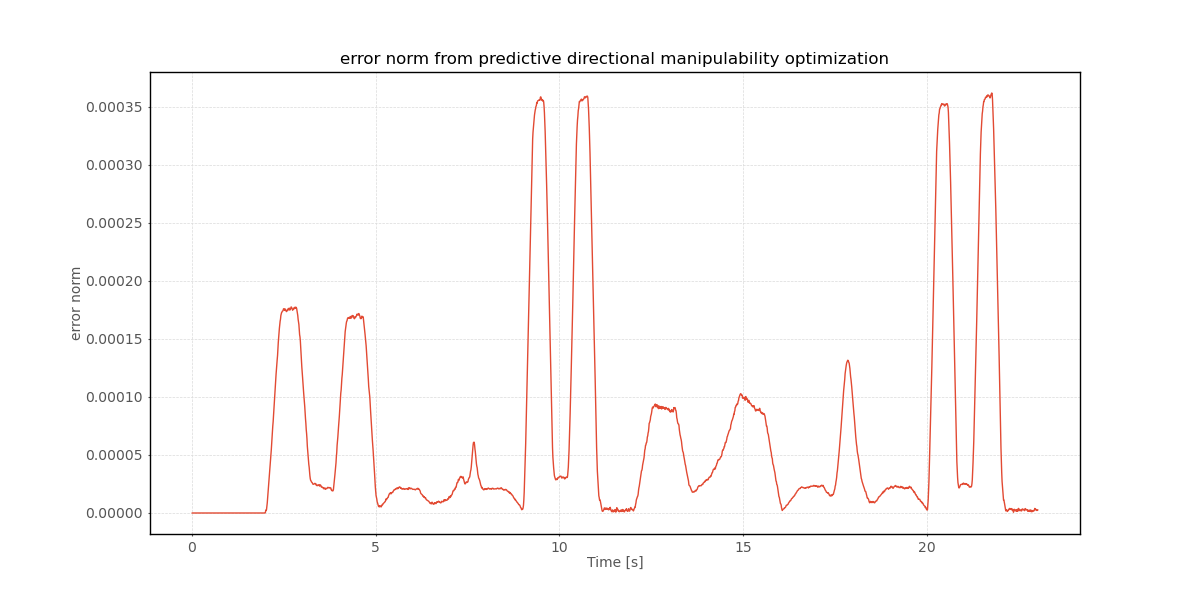

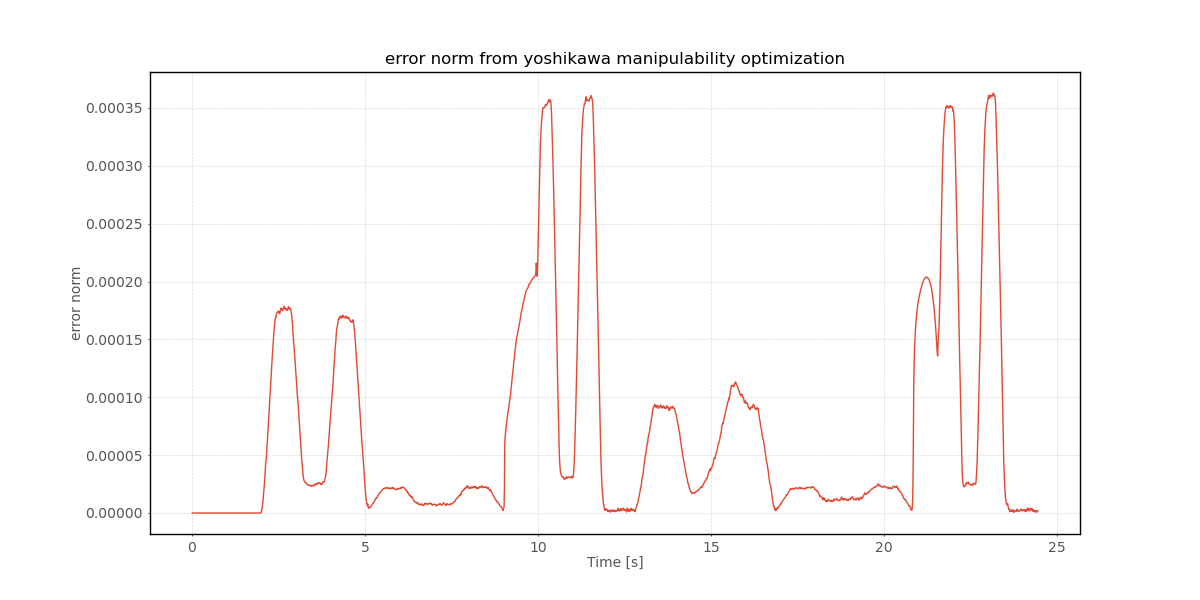

In [9]:
plotVariable(sim_qp.time_list, sim_qp.error_norm_list, "error norm from predictive directional manipulability optimization", "error norm")
plotVariable(sim_qp_yoshikawa.time_list, sim_qp_yoshikawa.error_norm_list, "error norm from yoshikawa manipulability optimization", "error norm")

## Practical Example: Robot Welding

As most cobot motions do not necessarily go through singularities, an example is analyzed where the cobot makes a motion in combination with the dual quaternion interpolator as was shown in chapter 4.0. The following code block generates the desired tasklist, which contains, for brevity, only parts of the welding trajectory shown in chapter 4.0.

In [10]:
# orientations for trajectory
quat0 = Quaternion.fromAxisAngle(np.pi*1.25, np.array([0,1,0]))
quat4 = Quaternion.fromAxisAngle(np.pi*1.5, np.array([0,1,0]))
quat5 = Quaternion.fromAxisAngle(np.pi*0.25, np.array([0,0,1])) 
quat6 = Quaternion.fromAxisAngle(-np.pi*0.5, np.array([0,0,1])) 
quat7 = Quaternion.fromAxisAngle(-np.pi, np.array([0,0,1])) 

# line segments
x9 = DualQuaternion.fromQuatPos(quat4, np.array([0.850, 0.0, 0.1]))
x10 = DualQuaternion.fromQuatPos(quat4, np.array([0.850, 0.0, 0.4]))
x11 = DualQuaternion.fromQuatPos(quat5*quat0, np.array([0.850, 0.0, 0.4]))

# first arc segments
x12 = DualQuaternion.fromQuatPos(quat0, np.array([0.90, -0.05, 0.4]))
x13 = DualQuaternion.fromQuatPos(quat6*quat0, np.array([0.850, -0.1, 0.4]))
x14 = DualQuaternion.fromQuatPos(quat7*quat0, np.array([0.80, -0.05, 0.4]))

# second line segments
x15 = DualQuaternion.fromQuatPos(quat7*quat0, np.array([0.80, 0.3, 0.4]))
x16 = DualQuaternion.fromQuatPos(quat6*quat0, np.array([0.80, 0.4, 0.4]))
x17 = DualQuaternion.fromQuatPos(quat6*quat0, np.array([0.1, 0.4, 0.4]))
x18 = DualQuaternion.fromQuatPos(quat6*quat0, np.array([0.1, 0.2, 0.6]))

# define the acceleration and jerk limits
a_cart_max = 3
j_cart_max = 30
a_ang_max = 3
j_ang_max = 30

# define desired cartesian velocites and maximum angular velocity
des_cart_vel = 0.03
max_ang_vel = 1.5

line_DQ_list = [x9, x10, x11]
arc_DQ_list = [x11, x12, x13, x14]
line2_DQ_list = [x14, x15, x16, x17]

trajectory = DQQBTrajectoryGenerator()

# initialize line and arc generators
line_generator = LineGenerator()
arc_generator = ArcGenerator()

line_segments1 = line_generator.generateSegments(line_DQ_list, des_cart_vel, max_ang_vel)
arc_segments = arc_generator.generateSegments(arc_DQ_list, des_cart_vel, max_ang_vel)
line_segments2 = line_generator.generateSegments(line2_DQ_list, des_cart_vel, max_ang_vel)

segments = line_segments1 + arc_segments + line_segments2

trajectory.generateDynamicTrajectory(segments, a_cart_max, j_cart_max, a_ang_max, j_ang_max)

robot_type = "extended"
fk = ForwardKinematics(robot_type)

q1 = np.array([deg2rad(10), deg2rad(30), 0, deg2rad(90), 0, deg2rad(40), 0, 0])

task_list = np.array([MoveJoint(q1, 5), MoveLinear(fk.getFK(q1), x9, 2),
                      MoveTrajectory(trajectory), MoveLinear(x17, x18, 1), WaitTime(1)])

iteration:  1
acceleration limit violated!
acceleration limit violated!
acceleration limit violated!
acceleration limit violated!
acceleration limit violated!
acceleration limit violated!
acceleration limit violated!
acceleration limit violated!
blendphases overlapped
iteration:  2
blendphases overlapped
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10


The following code blocks execute the welding trajectory for the Yoshikawa manipulability gradient and the proposed directional method. The trajectory does not run through singularities and is extended by an extra DoF to leverage the symmetry of the welding process. This gives the gradients extra null space for configuration optimization.

In [11]:
sim_yoshikawa_weld = Simulation(task_list, robot_type, method = "qp_yoshikawa")

sim_yoshikawa_weld.start()

In [12]:
sim_qp_weld = Simulation(task_list, robot_type, method = "qp")

sim_qp_weld.start()

The velocity norm is shown in the following plots to clearly show the difference between both trajectories. Here, it is visible that the directional manipulability optimization gives an advantage in the velocity spike norm. The directional manipulability gradient enables the robot to move in an optimized configuration before the robot has to adjust the joint configuration quickly and thus needs to traverse less distance with less effort to follow the desired trajectory when compared to the non-optimized standard approach. For this example, an improvement of up to $17$% is achieved.

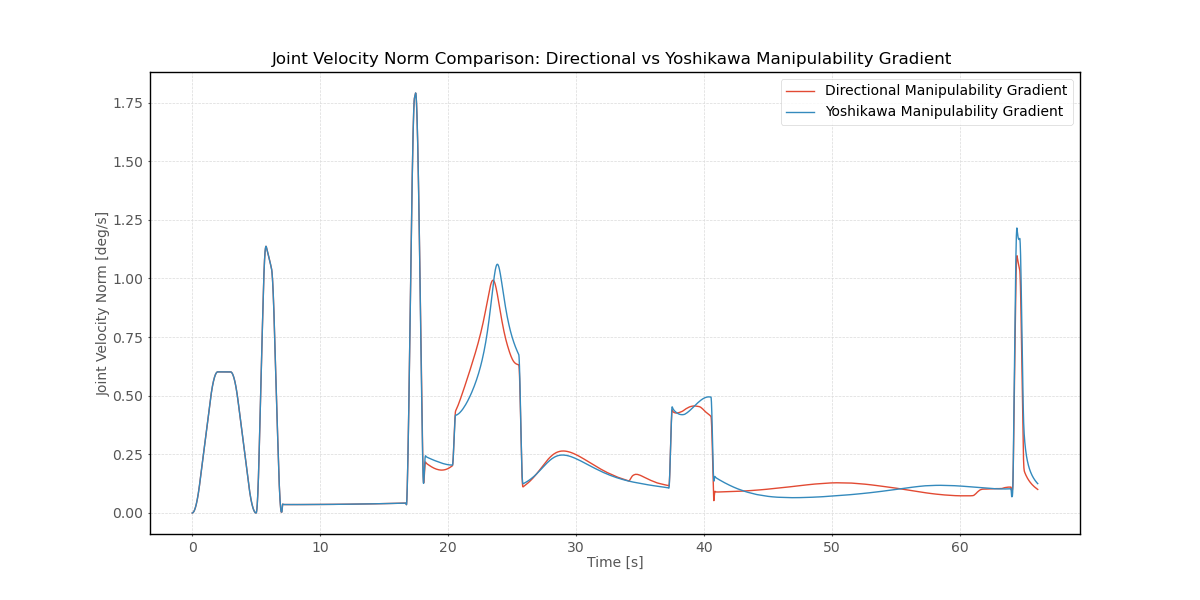

In [13]:
plotVelNormComparison(sim_qp_weld.time_list, sim_yoshikawa_weld.time_list, sim_qp_weld.q_dot_norm_list, sim_yoshikawa_weld.q_dot_norm_list)

## Speed Comparison

As Python is an interpreted language, it is executed line-by-line by an interpreter, which adds overhead. This significantly slows down the computation related to the dual quaternionic control methodology, when compared to compiled languages like C++. This means that the speed results in this Python environment are not necessarily representative of the speed advantage of the dual quaternion implementation. A comparison of the forward kinematics, inverse kinematics, and Jacobian computation was thus done in C++, where the speed advantages are significant. All tests were done on an **Intel Core i5-8265U CPU @ 1.60GHz x 8**.

<a id="table51"></a>
<table>
    <thead>
      <tr>
        <th>Computation</th>
        <th>Denavit-Hartenberg [ns]</th>
        <th>Dual Quaternion [ns]</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>Forward Kinematics</td>
        <td>$5287$</td>
        <td>$1263$</td>
      </tr>
      <tr>
        <td>Inverse Kinematics</td>
        <td>$106490$</td>
        <td>$61007$</td>
      </tr>
      <tr>
        <td>Jacobian</td>
        <td>$5756$</td>
        <td>$2137$</td>
      </tr>
    </tbody>
  </table>
  
<p style="text-align:center"><strong>Table 5.1</strong>: Average computation times of the forward kinematics, inverse kinematics and jacobian from C++ implementation. The average is computed over 10.000 random evaluations.</p>

The results shown in [Table 5.1](#table51) confirm the results presented in <cite id="pleev"><a href="#zotero%7C16222978%2FAFEHQ7QJ">(Dantam, 2021)</a></cite> and <cite id="kjzxp"><a href="#zotero%7C16222978%2FZZC2ARLA">(Miranda De Farias et al., 2019)</a></cite>. The implementations used closely resemble the ones from this Python script. The scripts are namely: <a href="./Simulation/ForwardKinematics.py">ForwardKinematics.py</a>, <a href="./Simulation/ForwardKinematicsDH.py">ForwardKinematicsDH.py</a> and <a href="./Simulation/InverseKinematics.py">InverseKinematics.py</a>. Here, speed improvements of up to $42-76$% are achievable. Especially for robots with high degrees of freedom, the speed improvements are significant as the difference between homogeneous transformation matrices and dual quaternions increase linearly as shown in <cite id="u92sm"><a href="#zotero%7C16222978%2FZZC2ARLA">(Miranda De Farias et al., 2019)</a></cite>. These improvements stem from the efficient dual quaternion algebra, where only a few operations and expensive sine and cosine evaluations are needed. [Table 5.2](#table52) gives a detailed overview and compares the operation counts of different calculations with the DH implementation. A reduction in the aforementioned trigonometric evaluations is especially notable.

<a id="table52"></a>
<table>
    <thead>
      <tr>
        <th>Computation</th>
        <th>Storage</th>
        <th>Multiplications</th>
        <th>Additions</th>
        <th>Sin/Cos Evaluations</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>Denavit-Hartenberg Tf.</td>
        <td>$16$</td>
        <td>$6$</td>
        <td>$0$</td>
        <td>$4$</td>
      </tr>
      <tr>
        <td>Dual Quaternion Tf.</td>
        <td>$8$</td>
        <td>$15$</td>
        <td>$3$</td>
        <td>$2$</td>
      </tr>
      <tr>
        <td>Dual Quaternion Tf. (revolute)</td>
        <td>$8$</td>
        <td>$7$</td>
        <td>$0$</td>
        <td>$2$</td>
      </tr>
      <tr>
        <td>Tf. Matrix Multiplication</td>
        <td>$-$</td>
        <td>$64$</td>
        <td>$48$</td>
        <td>$0$</td>
      </tr>
      <tr>
        <td>Dual Quaternion Multiplication</td>
        <td>$-$</td>
        <td>$48$</td>
        <td>$40$</td>
        <td>$0$</td>
      </tr>
      <tr>
        <td>DH Forward Kinematics 7DoF</td>
        <td>$112$</td>
        <td>$490$</td>
        <td>$336$</td>
        <td>$28$</td>
      </tr>
      <tr>
        <td>DQ Forward Kinematics 7DoF</td>
        <td>$56$</td>
        <td>$441$</td>
        <td>$301$</td>
        <td>$14$</td>
      </tr>
      <tr>
        <td>DQ Forward Kinematics 7DoF (revolute)</td>
        <td>$56$</td>
        <td>$385$</td>
        <td>$280$</td>
        <td>$14$</td>
      </tr>
    </tbody>
  </table>
  
<p style="text-align:center"><strong>Table 5.2</strong>: Operation count comparison between dual quaternion and Denavit-Hartenberg transformation, transformation matrix and dual quaternion multiplication and the forward kinematics respectively. </p>

[Table 5.2](#table52) also shows the dual quaternion transformation for the case of revolute joints. These are most common in cobots and omit parts of the exponential formula, which was introduced in <a href="./3.1_spatial_transformations_with_dual_quaternions.ipynb">Chapter 3.1</a>. Taking only the needed calculations into account, the resulting computation is super efficient compared to the common Denavit-Hartenberg transformations, which need four unique sine and cosine evaluations per transformation and substantially higher multiplication and addition amounts when compared to the dual quaternion implementation.

The efficient implementation and the light design of the proposed motion controller allow for low cycle times. The directional manipulability gradient computation in the C++ implementation takes $26.5\mu s$ on average, with a combination of runtime for the matrix, gradient, and bound updates, and solving of the OSQP problem, which takes $186.8\mu s$ on average, the real-time applicability is clearly given, for cycle times of $1-2ms$.

## Double Cover of $\mathcal{SE}(3)$ 

The double cover property from the dual quaternion set $\mathbb{H}$ is an essential advantage over $\mathcal{SE}(3)$. As cartesian cobot tasks are often set up by the hand-guiding mode, the user intuitively thinks that the cobot moves as taught. As shown in Chapter 3.0, this property can be leveraged to define directionality in the orientation interpolation. The following code blocks will show this feature in the simulation environment. First, two joint configurations are defined, as would be the case for hand-guiding the robot into the desired cartesian position from its home position. The forward kinematics are computed from these two joint configurations $q1$ and $q2$ to get the end-effector's dual quaternionic pose. 

In [14]:
robot_type = "normal"
fk = ForwardKinematics(robot_type)
fk_dh = ForwardKinematicsDH(robot_type)

q1 = np.array([deg2rad(-60), deg2rad(20), 0, deg2rad(70), 0, deg2rad(90), deg2rad(160)])
q2 = np.array([deg2rad(0), deg2rad(20), 0, deg2rad(70), 0, deg2rad(90), deg2rad(-120)])

x1 = fk.getFK(q1)
x2 = fk.getFK(q2)

T1 = fk_dh.getFK(q1)
T2 = fk_dh.getFK(q2)

x1_1  = DualQuaternion.fromTransformation(T1)
x2_1  = DualQuaternion.fromTransformation(T2)

print("Comparison of x1 and x1_1:")
print(x1)
print(x1_1)
print("\nComparison of x2 and x2_1:")
print(x2_1)
print(x2)

angle1 = (x1.real*x2.real.inverse()).getAngle()
angle2 = (x1_1.real*x2_1.real.inverse()).getAngle()

print("\nDual Quaternionic Contemplation: Angle between x1 and x2: ", angle1)
print("Transformation Matrix Contemplation:Angle between x1_1 and x2_1: ", angle2)

Comparison of x1 and x1_1:
DualQuaternion(Real: Quaternion(0.000, 0.940, -0.342, -0.000), Dual: Quaternion(-0.360, 0.168, 0.461, 0.302))
DualQuaternion(Real: Quaternion(0.000, 0.940, -0.342, 0.000), Dual: Quaternion(-0.360, 0.168, 0.461, 0.302))

Comparison of x2 and x2_1:
DualQuaternion(Real: Quaternion(-0.000, 0.866, -0.500, 0.000), Dual: Quaternion(-0.407, 0.245, 0.425, -0.235))
DualQuaternion(Real: Quaternion(0.000, -0.866, 0.500, -0.000), Dual: Quaternion(0.407, -0.245, -0.425, 0.235))

Dual Quaternionic Contemplation: Angle between x1 and x2:  5.93411945678072
Transformation Matrix Contemplation:Angle between x1_1 and x2_1:  0.3490658503988665


To simulate what a homogeneous matrix-based forward kinematics representation would yield, the same poses are also computed with DH-based forward kinematics, which lacks the double cover property. This can be seen by the mapping: $\mathcal{SE}(3) \to \mathbb{H}$, which in other words, is the conversion of a homogeneous transformation matrix to a unit dual quaternion. Here, in this example, the result will be the antipodal $-x2$, as can be seen by the print. The resulting interpolation will then run into joint limitations as the MoveLinear interpolation from pose $x1\_1$ to $x2\_1$ will take the shortest path instead of the long path, which is natural and intuitive to the user. This is also confirmed by the computed angle between $x1$, which is the respective pose to joint configuration $q1$, and the dual quaternionic representations of the second pose, where the angle between $x1$ and $x2$ is greater than $\pi$ and clearly represents the long path interpolation, whereas the angle between $x1\_1$ and $x2\_1$ is small.

Example 1: Interpolation with the original dual quaternion

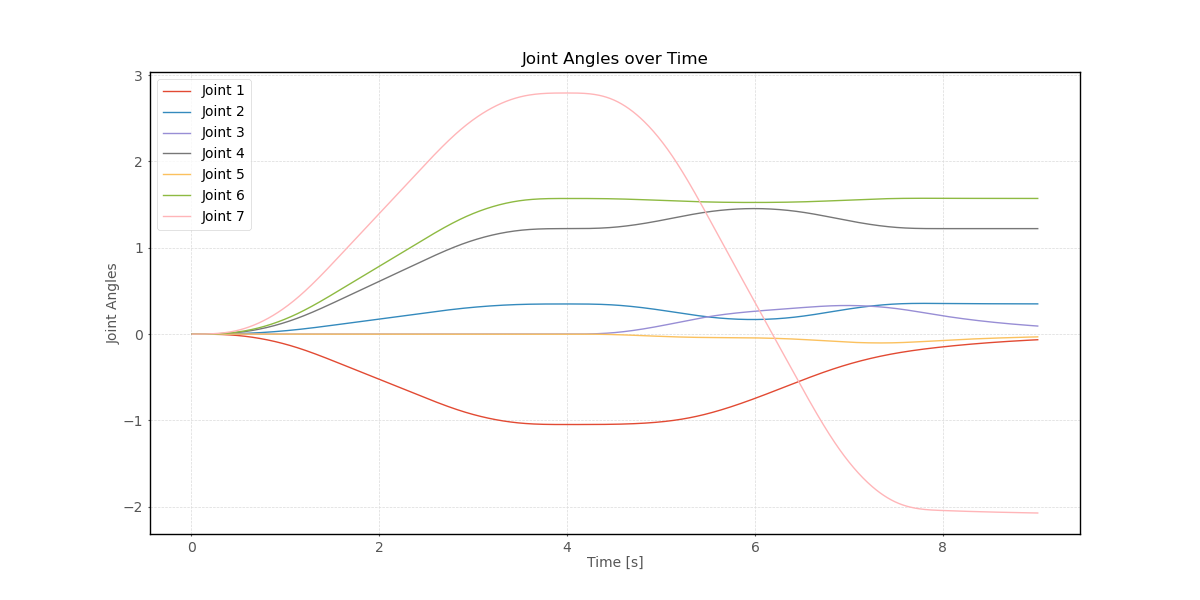

In [15]:
task_list = np.array([MoveJoint(q1, 4), MoveLinear(x1, x2, 4), WaitTime(1)])

sim = Simulation(task_list, robot_type, method = "classic")

sim.start()

plotJointAngles(sim.time_list, sim.q_list)

Example 2: Interpolation with the antipodal dual quaternion $x2\_1$

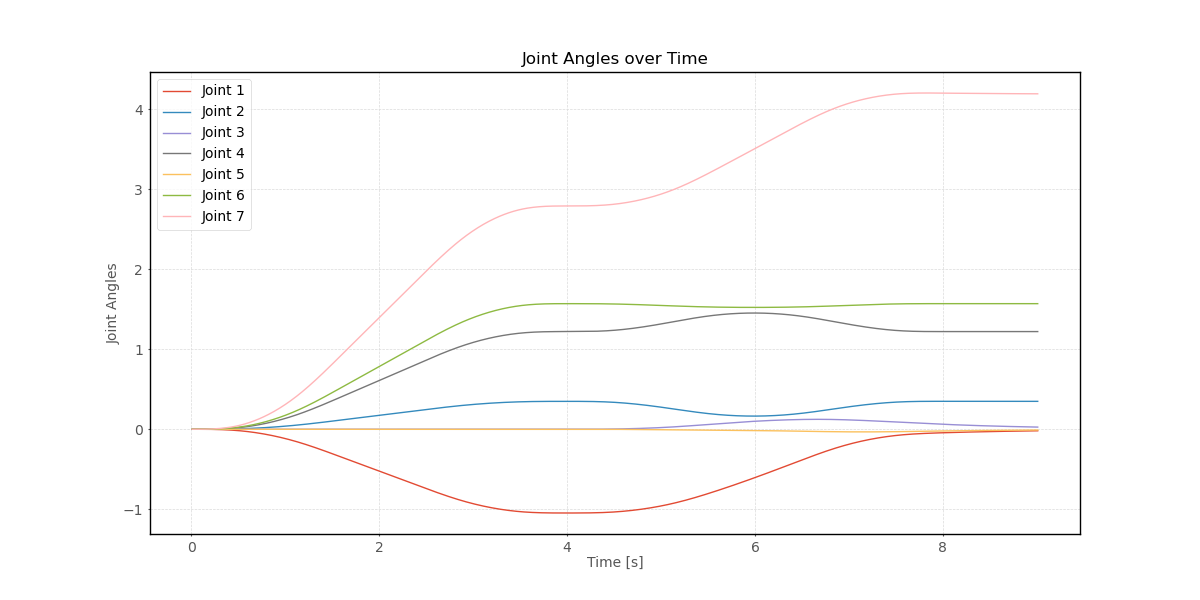

In [16]:
task_list = np.array([MoveJoint(q1, 4), MoveLinear(x1_1, x2_1, 4), WaitTime(1)])

sim = Simulation(task_list, robot_type, method = "classic")

sim.start()

plotJointAngles(sim.time_list, sim.q_list)

From the plots, it is evident that the incorrect direction of the orientation interpolation will lead to a joint limit violation in joint 7. This is often the case if orientation angles exceed 180 degrees cumulatively. For orientations below 180 degrees, the direction of the orientation unit quaternion retrieved from the homogeneous transformation matrices matches the one from the unit dual quaternions. Yet, this is a clear advantage of the dual quaternionic kinematics representation in motion planning. Different comparisons can be made by changing the joint angles in $q2$ from the joint configuration definition above.

This antipodal property/double cover of $\mathcal{SE}(3)$/$\mathcal{SO}(3)$ is also a usable feature in the dual quaternion interpolator. It can be leveraged here, especially in the circle definition. Non-expert users are often troubled by the short path interpolation. Here, the orientation difference of the three points, defining a circle segment, should not exceed $180$ degrees to work. This showcase can be seen in the following example. Three joint configurations are defined, resulting in three dual quaternionic poses. These poses are also generated via the DH-based forward kinematics.

In [17]:
robot_type = "normal"

fk = ForwardKinematics(robot_type)
fk_dh = ForwardKinematicsDH(robot_type)

q1 = np.array([deg2rad(-10), deg2rad(20), 0, deg2rad(70), 0, deg2rad(90), deg2rad(178)])
q2 = np.array([deg2rad(0), deg2rad(40), 0, deg2rad(50), 0, deg2rad(90), deg2rad(-110)])
q3 = np.array([deg2rad(10), deg2rad(20), 0, deg2rad(70), 0, deg2rad(90), deg2rad(-120)])

x1 = fk.getFK(q1)
x2 = fk.getFK(q2)
x3 = fk.getFK(q3)

T1 = fk_dh.getFK(q1)
T2 = fk_dh.getFK(q2)
T3 = fk_dh.getFK(q3)

x1_1  = DualQuaternion.fromTransformation(T1)           
x2_1  = DualQuaternion.fromTransformation(T2)
x3_1  = DualQuaternion.fromTransformation(T3)

The first example shows the working version with dual quaternionic kinematics representation. The dual quaternion interpolation follows the path defined by the user (no joint limit violations visible).

iteration:  1
acceleration limit violated!
acceleration limit violated!
acceleration limit violated!
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10


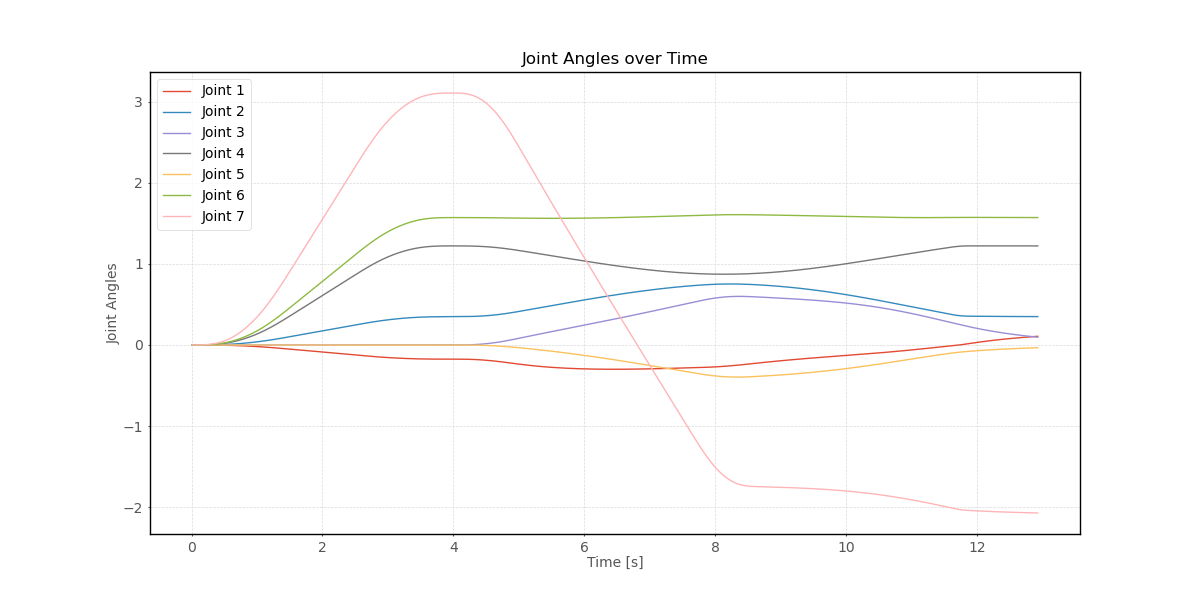

In [18]:
arc1 = [x1, x2, x3]

arc_generator = ArcGenerator()
arc_segments1 = arc_generator.generateSegments(arc1, 0.1, 3)


# initialize the DQQBTrajectoryGenerator
trajectory1 = DQQBTrajectoryGenerator()
trajectory1.generateDynamicTrajectory(arc_segments1, 2, 5, 2, 15)

task_list = np.array([MoveJoint(q1, 4), MoveTrajectory(trajectory1), WaitTime(1)])

sim = Simulation(task_list, robot_type, method = "classic")

sim.start()

plotJointAngles(sim.time_list, sim.q_list)

The second example shows the version which uses the homogenous transformation matrix kinematics. Here, the directionality of the interpolation is not given, which results in a joint limit violation of the cobot and a wrong interpolation of the circle segment.

iteration:  1
acceleration limit violated!
acceleration limit violated!
acceleration limit violated!
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10


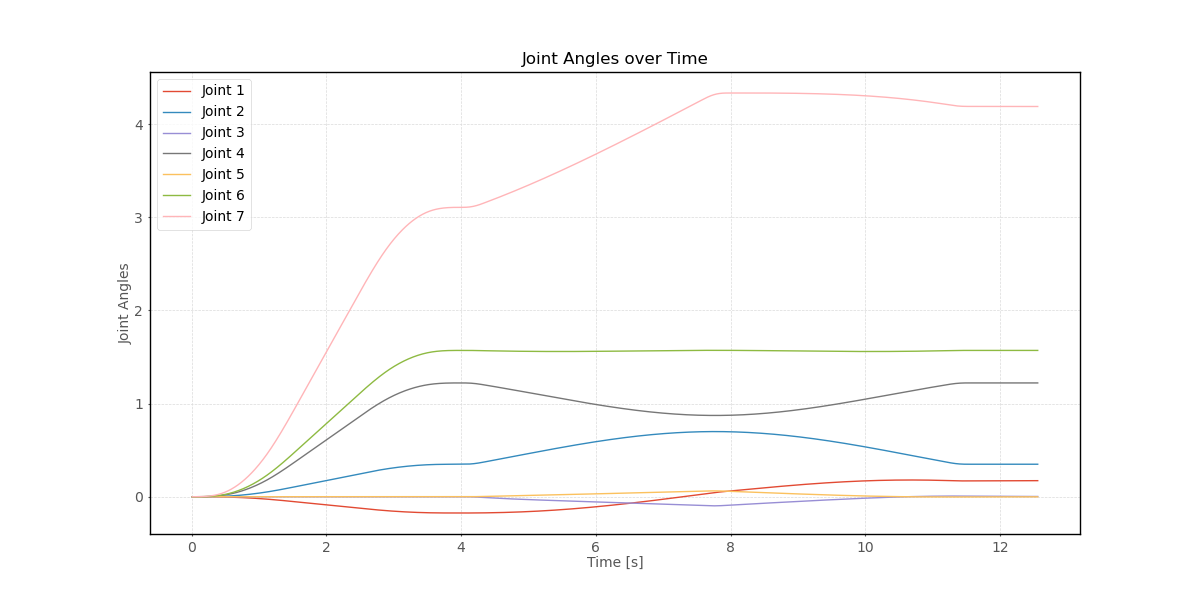

In [19]:
arc2 = [x1_1, x2_1, x3_1]

arc_segments2 = arc_generator.generateSegments(arc2, 0.1, 3)

trajectory2 = DQQBTrajectoryGenerator()
trajectory2.generateDynamicTrajectory(arc_segments2, 2, 5, 2, 15)

task_list = np.array([MoveJoint(q1, 4), MoveTrajectory(trajectory2), WaitTime(1)])

sim = Simulation(task_list, robot_type, method = "classic")

sim.start()

plotJointAngles(sim.time_list, sim.q_list)

# Literature

<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="zotero|16222978/AFEHQ7QJ"></i>Dantam, N. T. (2021). Robust and efficient forward, differential, and inverse kinematics using dual quaternions. <i>The International Journal of Robotics Research</i>, <i>40</i>(10–11), 1087–1105. <a href="https://doi.org/10.1177/0278364920931948">https://doi.org/10.1177/0278364920931948</a></div>
  <div class="csl-entry"><i id="zotero|16222978/ZZC2ARLA"></i>Miranda De Farias, C., Da Cruz Figueredo, L. F., &#38; Yoshiyuki Ishihara, J. (2019). Performance Study on dqRNEA – A Novel Dual Quaternion Based Recursive Newton-Euler Inverse Dynamics Algorithms. <i>2019 Third IEEE International Conference on Robotic Computing (IRC)</i>, 94–101. <a href="https://doi.org/10.1109/IRC.2019.00022">https://doi.org/10.1109/IRC.2019.00022</a></div>
</div>
<!-- BIBLIOGRAPHY END -->